<a href="https://colab.research.google.com/github/kiyuyeon/Ml_Dl/blob/master/20230619_chapter19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt


In [2]:
# 생성자 모델을 만듬
generator = Sequential()
generator.add(Dense(128*7*7,input_dim=100,activation=LeakyReLU(0.2))) # 노이즈 이미지 생성
generator.add(BatchNormalization()) # 데이터의 정규화 작업 : 분산
generator.add(Reshape((7,7,128))) #  Conv에 입력 가능한 자료로 변환
generator.add(UpSampling2D()) # 이미지 확대 14 * 14
generator.add(Conv2D(64,kernel_size=5,padding='same'))  # 14 * 14 size 변동 없음
generator.add(BatchNormalization()) # 정규화
generator.add(Activation(LeakyReLU(0.2))) #활성화 함수는 leakyrelu 사용
generator.add(UpSampling2D()) # 이미지 확대 28*28
generator.add(Conv2D(1,kernel_size=5,padding='same',activation='tanh'))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [3]:
# 판별자 모델 생성
discriminator = Sequential()
discriminator.add(Conv2D(64,kernel_size=5,strides=2,input_shape=(28,28,1),padding='same')) # 28*28 * 64
discriminator.add(Activation(LeakyReLU(0.2))) # 활성화 함수 지정
discriminator.add(Dropout(0.3)) # 30% node 꺼줌
discriminator.add(Conv2D(128,kernel_size=5,strides=2,padding='same')) # 28*28 * 128
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3)) #30% node 꺼줌
discriminator.add(Flatten()) # 1차원으로 지정
discriminator.add(Dense(1,activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainble=False
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_2 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [4]:
# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 1,065,474
Non-trainable params: 12,672
_________________________________________________________________


1/1 [==============================] - 0s 346ms/step
epoch:0  d_loss:0.7112  g_loss:0.6455
1/1 [==============================] - 0s 19ms/step
epoch:1  d_loss:0.4864  g_loss:0.2002
1/1 [==============================] - 0s 20ms/step
epoch:2  d_loss:0.5197  g_loss:0.0287
1/1 [==============================] - 0s 17ms/step
epoch:3  d_loss:0.5953  g_loss:0.0052
1/1 [==============================] - 0s 18ms/step
epoch:4  d_loss:0.6847  g_loss:0.0034
1/1 [==============================] - 0s 17ms/step
epoch:5  d_loss:0.6599  g_loss:0.0067
1/1 [==============================] - 0s 20ms/step
epoch:6  d_loss:0.5974  g_loss:0.0227
1/1 [==============================] - 0s 18ms/step
epoch:7  d_loss:0.5363  g_loss:0.0834
1/1 [==============================] - 0s 21ms/step
epoch:8  d_loss:0.4822  g_loss:0.2121
1/1 [==============================] - 0s 21ms/step
epoch:9  d_loss:0.4830  g_loss:0.3639
1/1 [==============================] - 0s 22ms/step
epoch:10  d_loss:0.4897  g_loss:0.4385
1/1 [===

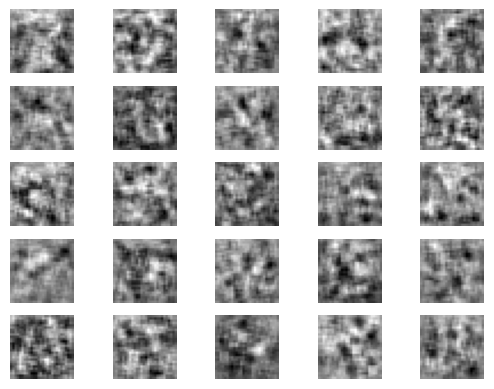

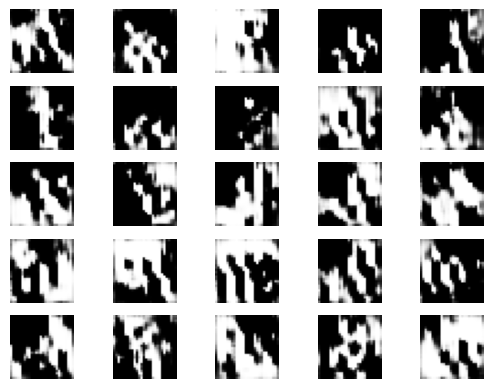

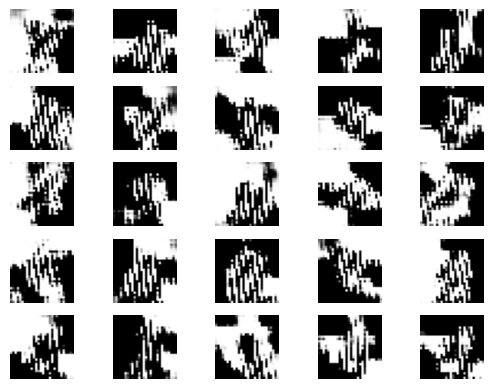

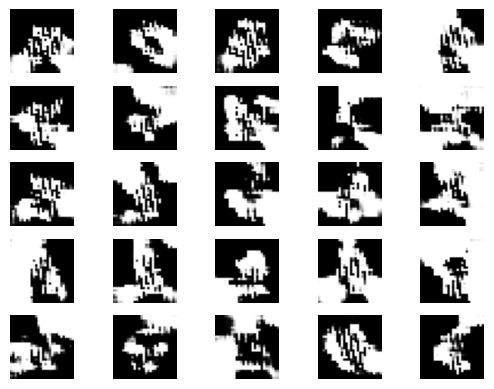

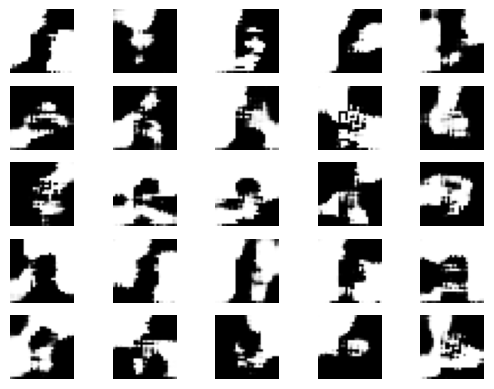

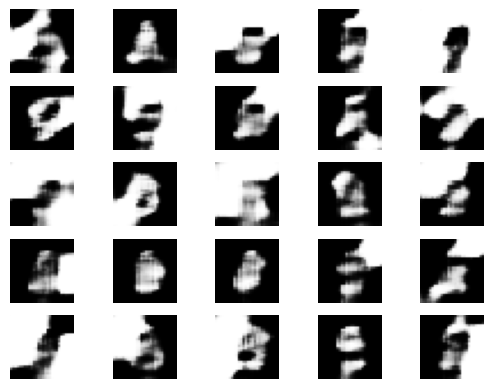

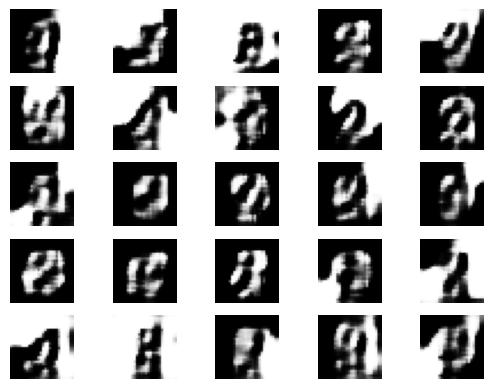

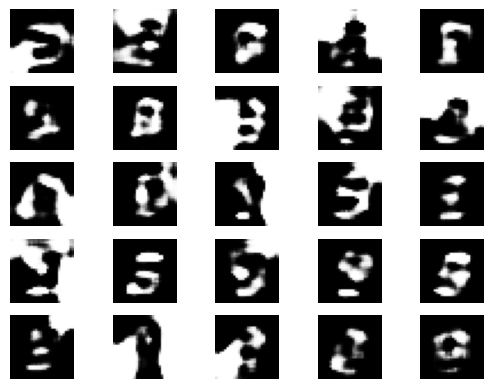

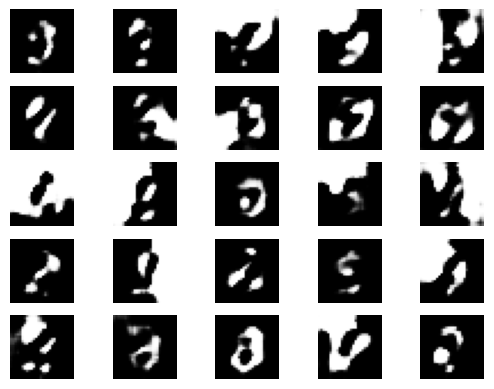

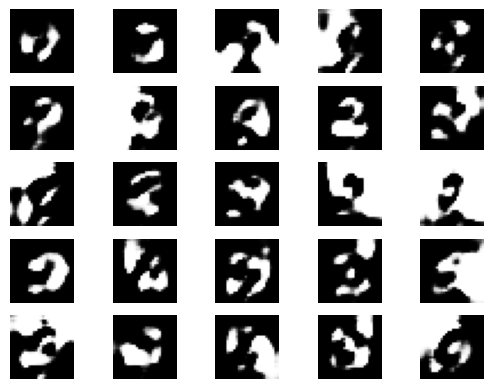

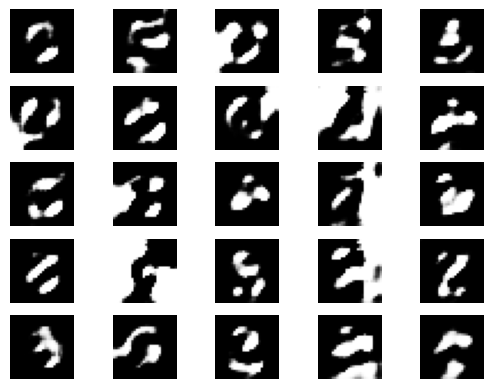

In [5]:
# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 이 장의 주요 내용과 관련이 없어
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  # 2000번 반복되고, 배치 사이즈는 32,  200번마다 결과가 저장되게 하였습니다.
